In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import librosa
import librosa.display

from utils.config import load_config

In [3]:
config = load_config()
train_dir_path = config['data_paths']['train_raw_path']
train_dir_path

'/app/data/raw/codecfake/train'

In [4]:
audio_files = os.listdir(train_dir_path)
audio_files

['F03_SSB13280206.wav',
 'F05_SSB13650058.wav',
 'SSB13650058.wav',
 'F02_SSB13650058.wav',
 'F04_SSB13280206.wav',
 'SSB13280206.wav',
 'F05_SSB13280206.wav',
 'F03_SSB13650058.wav',
 'F04_SSB13650058.wav',
 'F02_SSB13280206.wav',
 'F01_SSB13650058.wav',
 'F06_SSB13650058.wav',
 'F01_SSB13280206.wav',
 'F06_SSB13280206.wav']

## Extract Few Features

- **MFCCs**: Mel-frequency cepstral coefficients, a representation of the short-term power spectrum of sound.
- **Chroma**: Pertains to the 12 different pitch classes.
- **Mel Spectrogram**: A Mel-scaled power spectrogram.
- **Spectral Contrast**: Considers the spectral peak, valley, and their difference in each frequency sub-band.
- **Zero-Crossing Rate**: The rate at which the signal changes signs.

In [9]:
def extract_and_plot_features(real_path, fake_number):
    """Load real and fake audio files, extract features, and plot them side by side."""
    # Load the real audio file
    y_real, sr_real = librosa.load(real_path)
    
    # Generate fake file path based on fake_number
    fake_path = os.path.join(os.path.dirname(real_path),
                             f'F{str(fake_number).zfill(2)}_{os.path.basename(real_path)}')
    y_fake, sr_fake = librosa.load(fake_path)
    print(sr_real, sr_fake)
    # Extract features for both real and fake
    features = {}
    for label, y, sr in [('real', y_real, sr_real), ('fake', y_fake, sr_fake)]:
        features[label] = {
            'mfccs': librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13),
            'chroma': librosa.feature.chroma_stft(y=y, sr=sr),
            'mel': librosa.feature.melspectrogram(y=y, sr=sr),
            'contrast': librosa.feature.spectral_contrast(S=np.abs(librosa.stft(y)), sr=sr),
            'zero_cross': librosa.feature.zero_crossing_rate(y=y)
        }

    # Plotting
    fig, ax = plt.subplots(5, 2, figsize=(15, 20))

    titles = ['MFCC', 'Chroma', 'Mel-Spectrogram', 'Spectral Contrast', 'Zero Crossing Rate']
    for i, feature in enumerate(['mfccs', 'chroma', 'mel', 'contrast', 'zero_cross']):
        for j, label in enumerate(['real', 'fake']):
            data = features[label][feature]
            if feature != 'zero_cross':
                img = librosa.display.specshow(librosa.power_to_db(data, ref=np.max),
                                               x_axis='time', y_axis='mel', ax=ax[i, j])
                fig.colorbar(img, ax=ax[i, j], format="%+2.0f dB")
            else:
                ax[i, j].plot(data.T, label=f'{label} Zero Crossing Rate')
                ax[i, j].legend(loc="upper right")
            ax[i, j].set_title(f'{titles[i]} ({label})')
    
    plt.tight_layout()
    plt.show()

22050 22050


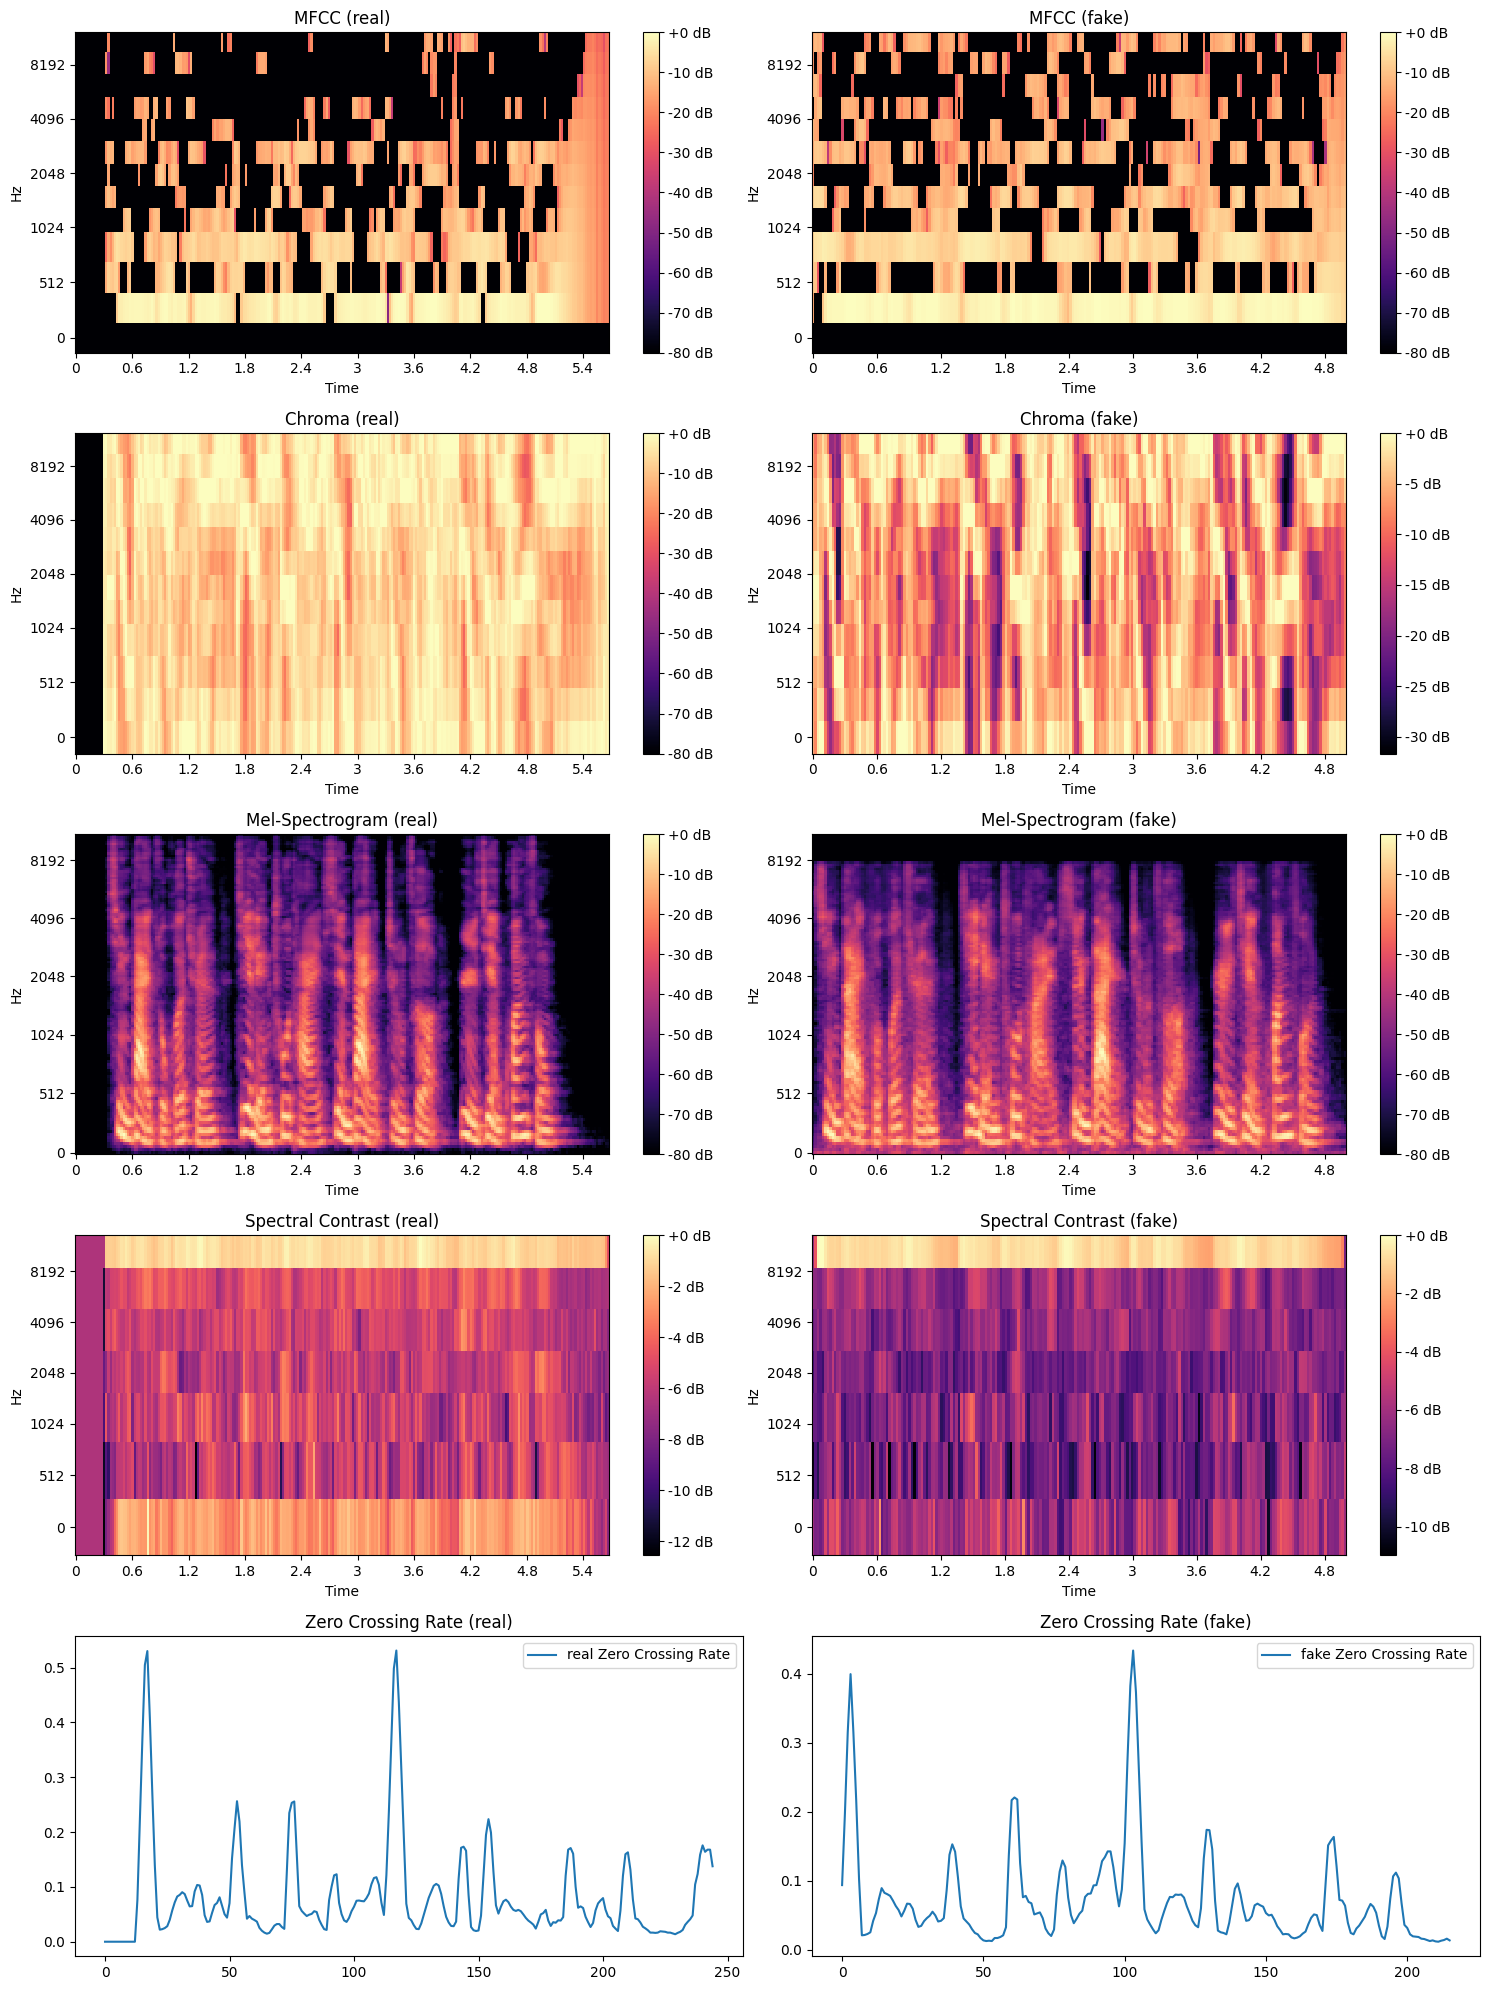

In [13]:
audio_file = os.path.join(train_dir_path, 'SSB13280206.wav')
extract_and_plot_features(audio_file, fake_number=1)